In [ ]:
!pip install -q scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 MB 19.2 MB/s eta 0:00:00


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()
import polars as pl
import matplotlib.pyplot as plt
import re, random
from collections import Counter
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import nltk
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def fast_clean(text):
    text = text.lower()
    text = re.sub(r"http\S+|[^a-zA-Z\s]", "", text)
    tokens = re.findall(r'\b\w+\b', text)
    return " ".join([t for t in tokens if t not in stop_words])

In [ ]:
dataset = load_dataset("artem9k/ai-text-detection-pile")['train']
texts, labels, seen = [], [], set()
for sample in dataset:
    raw = sample["text"]
    if raw and raw.strip():
        cleaned = fast_clean(raw)
        if cleaned and cleaned not in seen:
            seen.add(cleaned)
            texts.append(cleaned)
            labels.append(1 if sample["source"] == "ai" else 0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

(…)-00000-of-00007-bc5952582e004d67.parquet:   0%|          | 0.00/758M [00:00<?, ?B/s]

(…)-00001-of-00007-71c80017bc45f30d.parquet:   0%|          | 0.00/318M [00:00<?, ?B/s]

(…)-00002-of-00007-ee2d43f396e78fbc.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

(…)-00003-of-00007-529931154b42b51d.parquet:   0%|          | 0.00/137M [00:00<?, ?B/s]

(…)-00004-of-00007-b269dc49374a2c0b.parquet:   0%|          | 0.00/137M [00:00<?, ?B/s]

(…)-00005-of-00007-3dce5e05ddbad789.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

(…)-00006-of-00007-3d8a471ba0cf1c8d.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1392522 [00:00<?, ? examples/s]

In [ ]:
def plot_distribution(labels, title):
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n{title}")
    print(f"Total samples: {total}")
    for label in sorted(counter):
        name = "Human" if label == 0 else "AI"
        print(f"Label {label} ({name}): {counter[label]} samples")

    plt.figure(figsize=(6, 4))
    plt.bar(counter.keys(), counter.values(), tick_label=["Human", "AI"], color=["skyblue", "salmon"])
    plt.title(f"{title} (Total: {total})")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


Before Balancing
Total samples: 1383924
Label 0 (Human): 1022486 samples
Label 1 (AI): 361438 samples


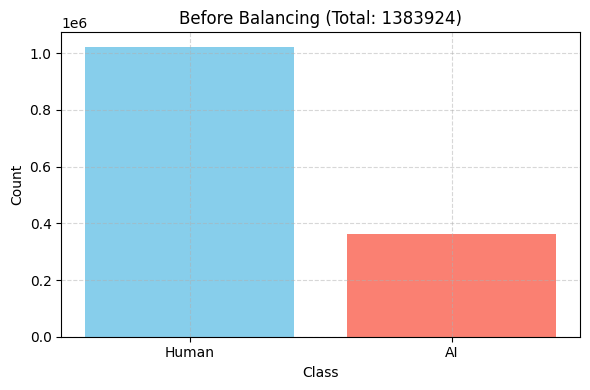

In [ ]:
plot_distribution(labels, "Before Balancing")

In [ ]:
ai_texts = [t for t, l in zip(texts, labels) if l == 1]
human_texts = [t for t, l in zip(texts, labels) if l == 0]
min_len = min(len(ai_texts), len(human_texts))
balanced_texts = random.sample(ai_texts, min_len) + random.sample(human_texts, min_len)
balanced_labels = [1]*min_len + [0]*min_len
combined = list(zip(balanced_texts, balanced_labels))
random.shuffle(combined)
balanced_texts, balanced_labels = zip(*combined)


After Balancing
Total samples: 722876
Label 0 (Human): 361438 samples
Label 1 (AI): 361438 samples


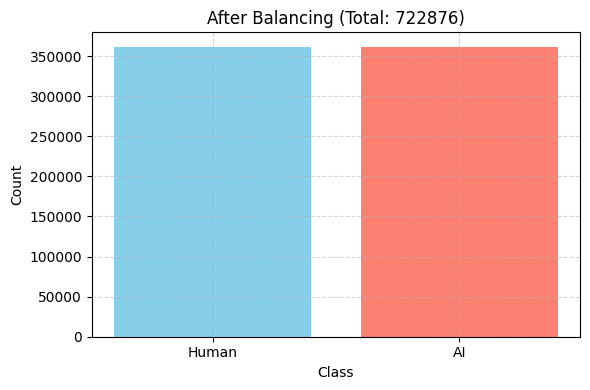

In [ ]:
plot_distribution(balanced_labels, "After Balancing")

In [ ]:
df = pl.DataFrame({"text": balanced_texts, "label": balanced_labels})
X_train_text, X_val_text, y_train, y_val = train_test_split(
    df["text"].to_list(), df["label"].to_list(), test_size=0.2, random_state=42)



In [ ]:
vectorizer = CountVectorizer(max_features=10000, stop_words='english')
X_train_bow = vectorizer.fit_transform(X_train_text)
X_val_bow = vectorizer.transform(X_val_text)


In [ ]:
models_basic = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [ ]:
for name, model in models_basic.items():
    print(f"\n Training {name}...")
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_val_bow)
    print(f" {name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=["Human", "AI"], zero_division=0))




 Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


 Logistic Regression Classification Report:
              precision    recall  f1-score   support

       Human       0.91      0.87      0.89     72326
          AI       0.87      0.92      0.89     72250

    accuracy                           0.89    144576
   macro avg       0.89      0.89      0.89    144576
weighted avg       0.89      0.89      0.89    144576


 Training Random Forest...
 Random Forest Classification Report:
              precision    recall  f1-score   support

       Human       0.93      0.79      0.85     72326
          AI       0.82      0.94      0.88     72250

    accuracy                           0.87    144576
   macro avg       0.87      0.87      0.86    144576
weighted avg       0.87      0.87      0.86    144576


 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:28:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 XGBoost Classification Report:
              precision    recall  f1-score   support

       Human       0.92      0.80      0.85     72326
          AI       0.82      0.93      0.87     72250

    accuracy                           0.86    144576
   macro avg       0.87      0.86      0.86    144576
weighted avg       0.87      0.86      0.86    144576



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
normalizer = Normalizer()
X_train_norm = normalizer.fit_transform(X_train_bow)
X_val_norm = normalizer.transform(X_val_bow)

models_optimized = {
    "SVM": SVC(kernel='rbf', C=1.0),
    "KNN": KNeighborsClassifier(n_neighbors=5)}

In [ ]:
for name, model in models_optimized.items():
    print(f"\n Training {name} with normalization + Intel optimization...")
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_val_norm)
    print(f" {name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=["Human", "AI"], zero_division=0))


 Training SVM with normalization + Intel optimization...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 SVM Classification Report:
              precision    recall  f1-score   support

       Human       0.95      0.89      0.92     72326
          AI       0.89      0.95      0.92     72250

    accuracy                           0.92    144576
   macro avg       0.92      0.92      0.92    144576
weighted avg       0.92      0.92      0.92    144576


 Training KNN with normalization + Intel optimization...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


 KNN Classification Report:
              precision    recall  f1-score   support

       Human       0.75      0.06      0.11     72326
          AI       0.51      0.98      0.67     72250

    accuracy                           0.52    144576
   macro avg       0.63      0.52      0.39    144576
weighted avg       0.63      0.52      0.39    144576

